# Mais uma 
O nome do arquivo já diz tudo. Dessa vez a transformação será baseada [neste notebook](https://github.com/Msanjayds/Kaggle_Projects/blob/master/1.%20Titanic%20Survival%20Prediction/Titanic_challenge.ipynb)

## Preparando o ambiente

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

## Carregando os dados

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/original/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/original/test.csv')

train.shape, test.shape

((891, 12), (418, 11))

## Analisando os dados

Criando uma classificação separada para quem morreu para facilitar a interpretação dos dados na análise.

In [4]:
data = train
data['Died']= 1 - data['Survived']

Análises sobre a morte de homens e de pessoas de meia idade já foi feita anteriormente. Destaco uma análise que não tinha sido feita: distribuição das mortes pelo valor pago na passagem.

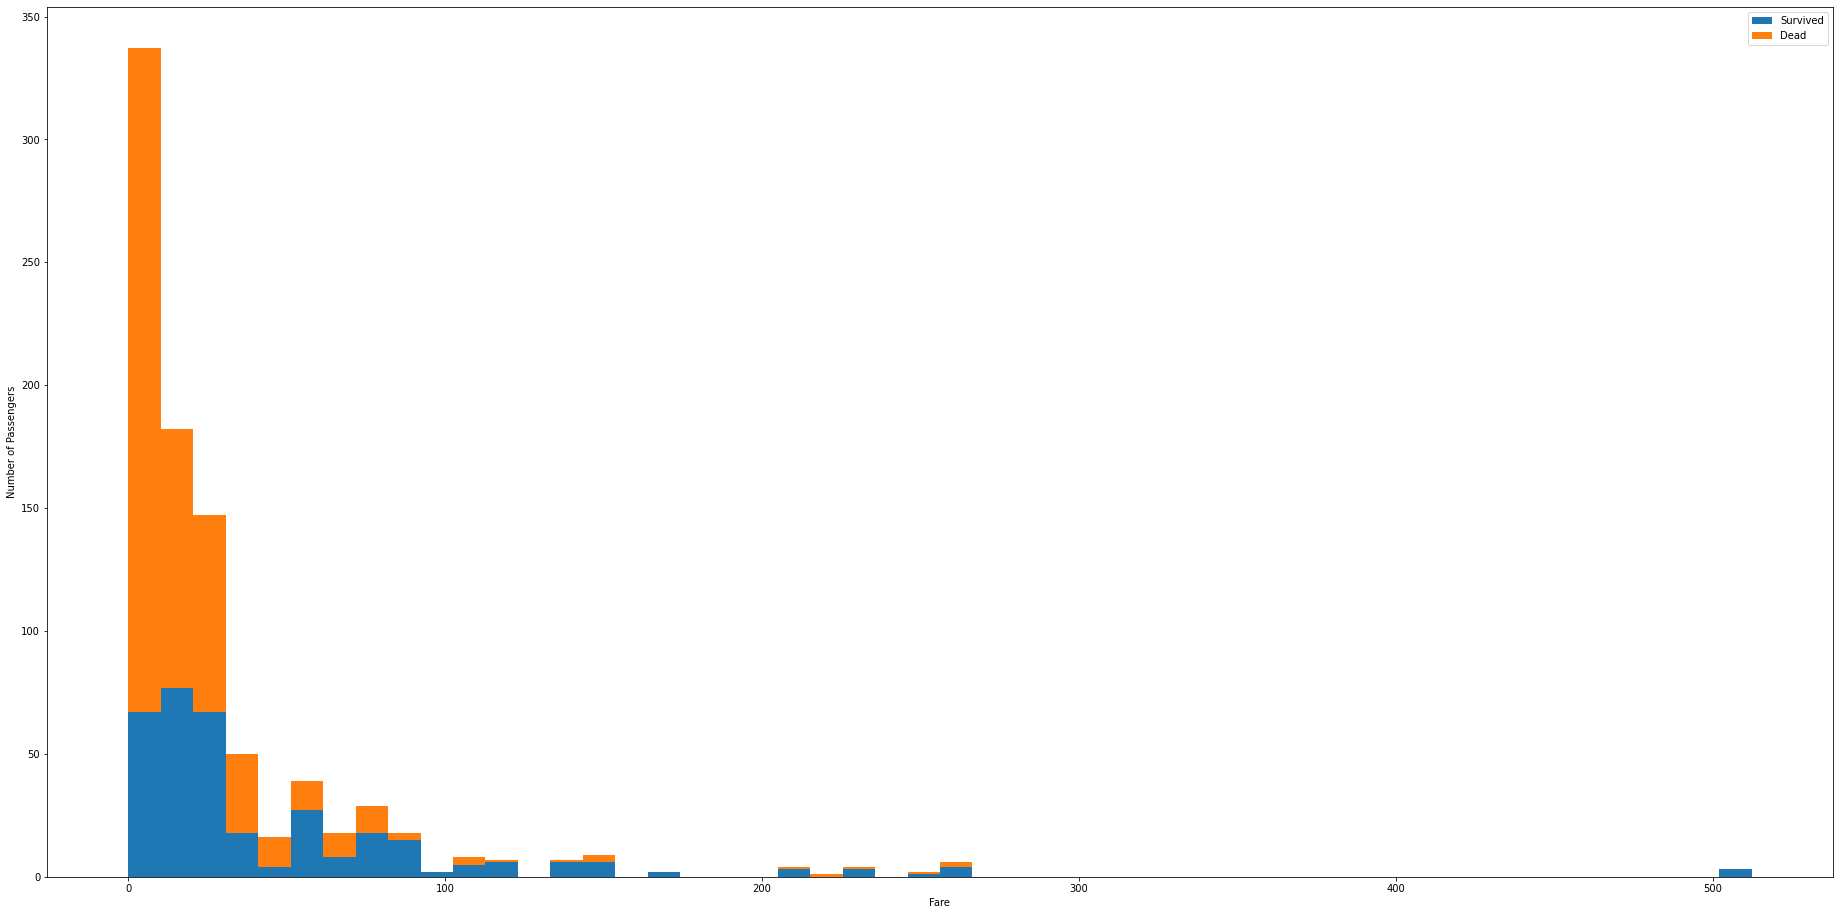

In [6]:
figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

Pessoas que pagaram um valor menor na passagem estão mais propensas a morrer, ainda que considerando o fato de que a maioria das pessoas pagou mais barato.

## Feature Engineering

In [11]:
x_train = train.drop(['Survived'],1)
y_train = train['Survived']
x_test = test

df_combined = x_train.append(x_test)
df_combined.shape

C:\Users\salat\AppData\Local\Temp/ipykernel_20588/1063705012.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train = train.drop(['Survived'],1)
C:\Users\salat\AppData\Local\Temp/ipykernel_20588/1063705012.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = x_train.append(x_test)


(1309, 12)

In [13]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [14]:
display_all(df_combined.tail().T)

,413,414,415,416,417
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Sex,male,female,male,male,male
Age,NaN,39.0,38.5,NaN,NaN
SibSp,0,0,0,0,1
Parch,0,0,0,0,1
Ticket,A.5. 3236,PC 17758,SOTON/O.Q. 3101262,359309,2668
Fare,8.05,108.9,7.25,8.05,22.3583
Cabin,NaN,C105,NaN,NaN,NaN
